# LangGraph Filter and Trim Messages - Python Cookbook

### llm

In [49]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
load_dotenv()

llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash',temperature=0)


### State - Message from Langchain

In [50]:

from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, trim_messages

from langgraph.graph.message import add_messages, RemoveMessage

messages = [AIMessage(f"Did you watch the game on 2024 IPL Final?", name="Gemini")]
messages.append(HumanMessage(f"Not ringing a bell. Can you tell me what happened?", name="Alice"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Gemini

Did you watch the game on 2024 IPL Final?
================================ Human Message =================================
Name: Alice

Not ringing a bell. Can you tell me what happened?


In [51]:
llm.invoke(messages)

AIMessage(content="Ah, the 2024 IPL Final! It was a pretty one-sided affair, largely dominated by **Kolkata Knight Riders (KKR)**.\n\nHere's a quick rundown:\n\n*   **Teams:** Kolkata Knight Riders (KKR) vs. Sunrisers Hyderabad (SRH)\n*   **Venue:** M. A. Chidambaram Stadium, Chennai\n*   **Date:** May 26, 2024\n\n**What happened:**\n\n1.  **SRH Batting Collapse:** KKR won the toss and elected to bowl first. SRH, known for their aggressive batting throughout the season, had a disastrous start. Their dangerous openers, Travis Head and Abhishek Sharma, fell very early.\n2.  **Starc's Brilliance:** Mitchell Starc, KKR's big-money signing, delivered a sensational opening spell, picking up crucial wickets and setting the tone. He was later named **Man of the Match**.\n3.  **Lowest Final Score:** SRH were bundled out for a mere **113 runs** in just 18.3 overs, which was the lowest total ever in an IPL final.\n4.  **KKR's Easy Chase:** Chasing a paltry target, KKR's batsmen made short work of

### Node

In [52]:
from langgraph.graph import MessagesState

def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

### Lets build a graph

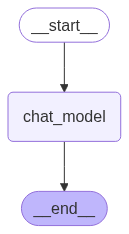

In [53]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
# simple invoke with all messages

out = graph.invoke({"messages": messages})
for msg in out["messages"]:
		msg.pretty_print()

================================== Ai Message ==================================
Name: Gemini

Did you watch the game on 2024 IPL Final?
================================ Human Message =================================
Name: Alice

Not ringing a bell. Can you tell me what happened?
================================== Ai Message ==================================

Ah, the 2024 IPL Final! It was a pretty one-sided affair, largely dominated by **Kolkata Knight Riders (KKR)**.

Here's a quick rundown:

*   **Teams:** Kolkata Knight Riders (KKR) vs. Sunrisers Hyderabad (SRH)
*   **Venue:** M. A. Chidambaram Stadium, Chennai
*   **Date:** May 26, 2024

**What happened:**

1.  **SRH Batting Collapse:** KKR won the toss and elected to bowl first. SRH, known for their aggressive batting throughout the season, had a disastrous start. Their dangerous openers, Travis Head and Abhishek Sharma, fell very early.
2.  **Starc's Brilliance:** Mitchell Starc, KKR's big-money signing, delivered a sensationa

### adding reducers

#### 1. Filter Message

In [55]:
def filter_messages(state: MessagesState):
  delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
  return {"messages": delete_messages}

### rebuild the graph

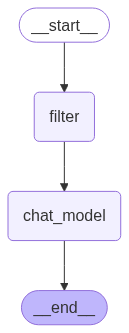

In [56]:
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [92]:
messages = [AIMessage("Hi.", name="Gemini", id="1")]
messages.append(HumanMessage("Hi.", name="Alice", id="2"))
messages.append(AIMessage("How are you?", name="Gemini", id="3"))
messages.append(HumanMessage("I am good, can we talk about IPL 2024 final.", name="Alice", id="4"))
out = graph.invoke({"messages": messages})
for msg in out["messages"]:
		msg.pretty_print()

================================== Ai Message ==================================
Name: Gemini

Hi.
================================ Human Message =================================
Name: Alice

Hi.
================================== Ai Message ==================================
Name: Gemini

How are you?
================================ Human Message =================================
Name: Alice

I am good, can we talk about IPL 2024 final.
================================== Ai Message ==================================

Absolutely! The IPL 2024 final was quite a memorable one, especially for KKR fans.

What would you like to discuss about it? Are you curious about the match highlights, specific player performances, or the overall outcome?


#### 2. Trim Messages
- this is based on tokens primarily

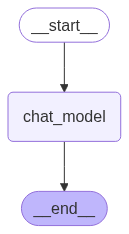

In [96]:
from langchain_core.messages.utils import count_tokens_approximately
def chat_model_node(state: MessagesState):
		messages = trim_messages(
			messages=state["messages"], 
			max_tokens=50, 
			strategy='last', 
			token_counter=ChatGoogleGenerativeAI(model='gemini-2.5-flash')
		)
		return {"messages": [llm.invoke(messages)]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = [*messages, *out['messages']]
messages.append(HumanMessage(f"Tell me where penguins live!", name="Alice"))
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Gemini', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Alice', id='2'),
 AIMessage(content='How are you?', additional_kwargs={}, response_metadata={}, name='Gemini', id='3'),
 HumanMessage(content='I am good, can we talk about IPL 2024 final.', additional_kwargs={}, response_metadata={}, name='Alice', id='4'),
 AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Gemini', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Alice', id='2'),
 AIMessage(content='How are you?', additional_kwargs={}, response_metadata={}, name='Gemini', id='3'),
 HumanMessage(content='I am good, can we talk about IPL 2024 final.', additional_kwargs={}, response_metadata={}, name='Alice', id='4'),
 AIMessage(content='Absolutely! The IPL 2024 final was quite a memorable one, especially for KKR fans.\n\nWhat would you like to discuss abo

In [60]:
trim_messages(
			messages=messages, 
			max_tokens=10, 
			strategy='last', 
			token_counter=count_tokens_approximately
		)


[]

In [99]:
messages_out_trim = graph.invoke({'messages': messages})
for msg in messages_out_trim['messages']:
		msg.pretty_print()

================================== Ai Message ==================================
Name: Gemini

Hi.
================================ Human Message =================================
Name: Alice

Hi.
================================== Ai Message ==================================
Name: Gemini

How are you?
================================ Human Message =================================
Name: Alice

I am good, can we talk about IPL 2024 final.
================================== Ai Message ==================================

Absolutely! The IPL 2024 final was quite a memorable one, especially for KKR fans.

What would you like to discuss about it? Are you curious about the match highlights, specific player performances, or the overall outcome?
================================ Human Message =================================
Name: Alice

Tell me where penguins live!
================================ Human Message =================================
Name: Alice

Tell me where penguins live!
=====